# <p style="text-align: center;">Capstone Project - Tabular Data Model</p>

## Introduction

### Approach

In this version (1) of the code, 

* Section 2 deals with data input
* Section 3 provides the necessary data preparation
* Section 4 sets the initial model parameters 
* Section 5 trains & tunes the model
* Section 6 deals with testing
* Section 7 Misc (saving modle, etc.)

### Literature Review

None

## Input Data

### Packages & Methods

In [1]:
#!pip install sweetviz

In [2]:
#!pip install xgboost

In [3]:
#Start importing
import numpy as np
from numpy import *
import pandas as pd
from pandas import DataFrame
from pandas import Series
from copy import deepcopy
import gzip
import os
import json
import re
import datetime as dt
import pprint
pd.options.display.max_columns = 999
from collections import Counter
import sys
from contextlib import contextmanager

import seaborn as sns
sns.set(style="darkgrid")  # default style
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.image as mpimg
from matplotlib.ticker import ScalarFormatter
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import matplotlib
import matplotlib.tri as tri
plt.rcParams['contour.negative_linestyle']='solid'  # to force negative contours to have solid lines
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['figure.figsize'] = 10,10
import plotly.graph_objects as go

import sweetviz as sv

from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale,StandardScaler,RobustScaler,MinMaxScaler,MaxAbsScaler,Normalizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score,cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, average_precision_score, log_loss

#models
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier

import joblib
import pickle

RANDOM_SEED = 711                       # Set a random seed for reproducibility!

### Read data from input files

In [4]:
# Base directories/files
local_base_dir = '/tf/mount/0 Berkeley/0 Spring 2024/w210 Capstone/Project/mimic_data'
main_json_dir = '/mimic_iv_multilabel__json_files__20240302'

In [5]:
# Input Json data files
train_inp_file   = local_base_dir + main_json_dir + '/' + 'train_set__chexpert.json'
val_inp_file     = local_base_dir + main_json_dir + '/' + 'validation_set__chexpert.json'
test_inp_file    = local_base_dir + main_json_dir + '/' + 'test_set__chexpert.json'

In [6]:
def load_data(file_path, data_type):
    """
    Load data from a JSON file and add a column indicating the data type (train, validate, test).
    Parameters:
    - file_path: Path to the JSON file.
    - data_type: Type of data (train, validate, test).
    Returns:
    - DataFrame with loaded data and additional column for data type.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    df = pd.DataFrame()
    df['patient_id']   = pd.Series(data['patient_id']).astype(float).astype("Int64")
    df['visit_id']     = pd.Series(data['visit_id']).astype(float).astype("Int64")
    df['study_id']     = pd.Series(data['study_id']).astype(float).astype("Int64")
    df['temperature']  = pd.Series(data['temperature']).astype(float)
    df['heartrate']    = pd.Series(data['heartrate']).astype(float)
    df['resprate']     = pd.Series(data['resprate']).astype(float)
    df['o2sat']        = pd.Series(data['o2sat']).astype(float)
    df['sbp']          = pd.Series(data['sbp']).astype(float)
    df['dbp']          = pd.Series(data['dbp']).astype(float)
    df['pain']         = pd.Series(data['pain']).astype("Int64")
    df['acuity']       = pd.Series(data['acuity']).astype("Int64")
    df['atelectasis']  = pd.Series(data['atelectasis']).astype(float)
    df['cardiomegaly'] = pd.Series(data['cardiomegaly']).astype(float)
    df['edema']        = pd.Series(data['edema']).astype(float)
    df['lung_opacity'] = pd.Series(data['lung_opacity']).astype(float)
    df['pleural_effusion'] = pd.Series(data['pleural_effusion']).astype(float)
    df['pneumonia'] = pd.Series(data['pneumonia']).astype(float)
    df['data_type'] = data_type
    
    return df

In [7]:
# Load non-sample data
train_df = load_data(train_inp_file, 'train')
val_df = load_data(val_inp_file, 'validate')
test_df = load_data(test_inp_file, 'test')

In [8]:
# Combine DataFrames
combined_df = pd.concat([train_df, val_df, test_df])

# Remove duplicates
combined_df = combined_df.drop_duplicates(subset=['patient_id', 'study_id', 'data_type'], keep='last').reset_index(drop=True)

In [9]:
# Display the combined DataFrame
print(combined_df.info())
combined_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14443 entries, 0 to 14442
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        14443 non-null  Int64  
 1   visit_id          14443 non-null  Int64  
 2   study_id          14443 non-null  Int64  
 3   temperature       14443 non-null  float64
 4   heartrate         14443 non-null  float64
 5   resprate          14443 non-null  float64
 6   o2sat             14443 non-null  float64
 7   sbp               14443 non-null  float64
 8   dbp               14443 non-null  float64
 9   pain              14443 non-null  Int64  
 10  acuity            14443 non-null  Int64  
 11  atelectasis       14443 non-null  float64
 12  cardiomegaly      14443 non-null  float64
 13  edema             14443 non-null  float64
 14  lung_opacity      14443 non-null  float64
 15  pleural_effusion  14443 non-null  float64
 16  pneumonia         14443 non-null  float6

,patient_id,visit_id,study_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,atelectasis,cardiomegaly,edema,lung_opacity,pleural_effusion,pneumonia,data_type
0,10000935,26381316,51178377,97.6,117.0,18.0,95.0,128.0,74.0,10,3,0.0,0.0,0.0,1.0,0.0,0.0,train
1,10000980,29654838,59988438,97.8,57.0,18.0,100.0,180.0,88.0,0,2,0.0,0.0,0.0,0.0,1.0,0.0,train


### Upload Processed Image File 
For consistent input between image an dtabular model

In [10]:
image_base_dir = '/tf/mount/0 Berkeley/0 Spring 2024/w210 Capstone/Project/mimic_data/mimic_images'
latest_processed_file = 'Processed_Image_Data_March_11_2024.csv'
latest_process_file_path = os.path.join(image_base_dir, latest_processed_file)

In [11]:
# Read the image processed CSV file into a dataframe
image_processed_df = pd.read_csv(latest_process_file_path)
print(image_processed_df.info())
image_processed_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16877 entries, 0 to 16876
Data columns (total 40 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   patient_id                                  16877 non-null  int64  
 1   study_id                                    16877 non-null  int64  
 2   atelectasis                                 16877 non-null  float64
 3   cardiomegaly                                16877 non-null  float64
 4   edema                                       16877 non-null  float64
 5   lung_opacity                                16877 non-null  float64
 6   pleural_effusion                            16877 non-null  float64
 7   pneumonia                                   16877 non-null  float64
 8   prev_data_type                              16877 non-null  object 
 9   prev_is_sample                              16877 non-null  bool   
 10  dicom_id  

,patient_id,study_id,atelectasis,cardiomegaly,edema,lung_opacity,pleural_effusion,pneumonia,prev_data_type,prev_is_sample,dicom_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,jpg_filename,anomaly,no_findings,set,train_6_unb_m,test_6_unb_m,val_6_unb_m,train_6_bal_m,train_6_unb_s,test_6_unb_s,val_6_unb_s,train_6_bal_s,train_4_unb_m,test_4_unb_m,val_4_unb_m,train_4_bal_m,train_4_unb_s,test_4_unb_s,val_4_unb_s,train_4_bal_s
0,19998562,52252154,0.0,0.0,0.0,0.0,1.0,0.0,test,False,e3e5f8c3-14429887-b1181522-445ec3a8-110663c3.jpg,CHEST (PA AND LAT),PA,3056,2544,21660321,224219.015,CHEST (PA AND LAT),postero-anterior,Erect,https://physionet.org/files/mimic-cxr-jpg/2.0....,1,False,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1
1,13831580,55371824,0.0,0.0,0.0,0.0,0.0,0.0,test,False,f34f44ce-0feade9a-8a71da5b-6e080e42-643cb41d.jpg,CHEST (PA AND LAT),PA,3056,2544,22031114,210815.687,CHEST (PA AND LAT),postero-anterior,Erect,https://physionet.org/files/mimic-cxr-jpg/2.0....,1,True,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0


In [12]:
# Selecting the required columns from each dataframe
combined_df_selected = combined_df[['patient_id', 'study_id', 
                                    'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 
                                    #'data_type', not needed since we changed th etrain, val, test set for the final 4 pathology sets
                                   ]]
image_processed_df_selected = image_processed_df[['patient_id', 'study_id', 
                                                  'atelectasis', 'cardiomegaly', 'lung_opacity', 'pleural_effusion', 'no_findings', 
                                                  'train_4_unb_s', 'test_4_unb_s', 'val_4_unb_s', 'train_4_bal_s']]
# Merging the dataframes on 'patient_id' and 'study_id'
merged_df = pd.merge(combined_df_selected, image_processed_df_selected, on=['patient_id', 'study_id'], how='inner')

# Use patient_id as the index
merged_df.set_index('patient_id', inplace=True)

conditions = [
    (merged_df['no_findings'] == 1),
    (merged_df['atelectasis'] == 1),
    (merged_df['cardiomegaly'] == 1),
    (merged_df['lung_opacity'] == 1),
    (merged_df['pleural_effusion'] == 1)
]
choices = [0, 1, 2, 3, 4]
merged_df['target'] = np.select(conditions, choices, default=0)

# Displaying the merged dataframe
print(merged_df.info())
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 14443 entries, 10000935 to 17206661
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   study_id          14443 non-null  Int64  
 1   temperature       14443 non-null  float64
 2   heartrate         14443 non-null  float64
 3   resprate          14443 non-null  float64
 4   o2sat             14443 non-null  float64
 5   sbp               14443 non-null  float64
 6   dbp               14443 non-null  float64
 7   pain              14443 non-null  Int64  
 8   acuity            14443 non-null  Int64  
 9   atelectasis       14443 non-null  float64
 10  cardiomegaly      14443 non-null  float64
 11  lung_opacity      14443 non-null  float64
 12  pleural_effusion  14443 non-null  float64
 13  no_findings       14443 non-null  bool   
 14  train_4_unb_s     14443 non-null  int64  
 15  test_4_unb_s      14443 non-null  int64  
 16  val_4_unb_s       14443 non-null  i

,study_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,atelectasis,cardiomegaly,lung_opacity,pleural_effusion,no_findings,train_4_unb_s,test_4_unb_s,val_4_unb_s,train_4_bal_s,target
patient_id,,,,,,,,,,,,,,,,,,,
10000935,51178377,97.6,117.0,18.0,95.0,128.0,74.0,10,3,0.0,0.0,1.0,0.0,False,1,0,0,0,3
10000980,59988438,97.8,57.0,18.0,100.0,180.0,88.0,0,2,0.0,0.0,0.0,1.0,False,1,0,0,1,4
10001176,53186264,101.3,97.0,18.0,93.0,168.0,58.0,6,3,0.0,0.0,1.0,0.0,False,1,0,0,0,3
10001401,51065211,97.8,67.0,20.0,95.0,90.0,43.0,8,2,1.0,0.0,0.0,0.0,False,1,0,0,0,1
10004322,57662923,97.5,91.0,17.0,100.0,126.0,81.0,0,3,0.0,0.0,1.0,0.0,False,1,0,0,1,3


In [13]:
# Performed once already and results are stored in html file
'''
alldata_report = sv.analyze(merged_df)
#display the report
alldata_report.show_html('AllData.html')
#check html page to understand the given data
'''
None

In [14]:
# Create separate dataframes for train, validate, and test
train_4_unb_s = merged_df[merged_df['train_4_unb_s'] == 1]
test_4_unb_s  = merged_df[merged_df['test_4_unb_s']  == 1]
val_4_unb_s   = merged_df[merged_df['val_4_unb_s']   == 1]
train_4_bal_s = merged_df[merged_df['train_4_bal_s'] == 1]

# Split each dataframe into X (features) and y (labels)
# Define columns for X and y
X_columns = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']
y_columns = ['target']  # as per team agreement

# Split for 4_unb_s
X_train_4_unb_s = train_4_unb_s[X_columns]
y_train_4_unb_s = train_4_unb_s[y_columns]
X_val_4_unb_s   = val_4_unb_s[X_columns]
y_val_4_unb_s   = val_4_unb_s[y_columns]
X_test_4_unb_s  = test_4_unb_s[X_columns]
y_test_4_unb_s  = test_4_unb_s[y_columns]

# Split for 4_bal_s
X_train_4_bal_s = train_4_bal_s[X_columns]
y_train_4_bal_s = train_4_bal_s[y_columns]
X_val_4_bal_s   = val_4_unb_s[X_columns]     # intentionally the same as X_val_6_unb_m
y_val_4_bal_s   = val_4_unb_s[y_columns]     # intentionally the same as unb
X_test_4_bal_s  = test_4_unb_s[X_columns]    # intentionally the same as unb
y_test_4_bal_s  = test_4_unb_s[y_columns]    # intentionally the same as unb

Verify results

In [15]:
# Create a dictionary to hold all the X and Y dataframes
dataframes = {
    # Split for 4_unb_s
    'X_train_4_unb_s' : X_train_4_unb_s,
    'y_train_4_unb_s' : y_train_4_unb_s,
    'X_val_4_unb_s'   : X_val_4_unb_s,
    'y_val_4_unb_s'   : y_val_4_unb_s,
    'X_test_4_unb_s'  : X_test_4_unb_s,
    'y_test_4_unb_s'  : y_test_4_unb_s,
    # Split for 4_bal_s
    'X_train_4_bal_s' : X_train_4_bal_s,
    'y_train_4_bal_s' : y_train_4_bal_s,
    'X_val_4_bal_s'   : X_val_4_unb_s,
    'y_val_4_bal_s'   : y_val_4_unb_s,
    'X_test_4_bal_s'  : X_test_4_unb_s,
    'y_test_4_bal_s'  : y_test_4_unb_s,
}
# Loop through the dictionary and print out the shapes
for name, df in dataframes.items():
    print(f"{name} shape: {df.shape}")

X_train_4_unb_s shape: (7633, 8)
y_train_4_unb_s shape: (7633, 1)
X_val_4_unb_s shape: (1912, 8)
y_val_4_unb_s shape: (1912, 1)
X_test_4_unb_s shape: (1911, 8)
y_test_4_unb_s shape: (1911, 1)
X_train_4_bal_s shape: (2065, 8)
y_train_4_bal_s shape: (2065, 1)
X_val_4_bal_s shape: (1912, 8)
y_val_4_bal_s shape: (1912, 1)
X_test_4_bal_s shape: (1911, 8)
y_test_4_bal_s shape: (1911, 1)


Check distribution of classes in 4_unb_s

In [16]:
y_train_4_unb_s['target'].value_counts()

target
0    5376
3     872
1     535
2     533
4     317
Name: count, dtype: int64

In [17]:
# Get the percentage of the total for each unique value in 'target' column
y_train_4_unb_s['target'].value_counts(normalize=True) * 100

target
0    70.431023
3    11.424080
1     7.009040
2     6.982838
4     4.153020
Name: proportion, dtype: float64

Note:
* train set will b eused for CV
* val set will b eused for testing
* test set will not be used for now and will ba saved for testing the fusion models

Store train, validation data, and test data for 4_bal_s case

In [18]:
X_train_4_bal_s.to_csv('X_train_4_bal_s.csv', index=True)
y_train_4_bal_s.to_csv('y_train_4_bal_s.csv', index=True)
X_val_4_bal_s.to_csv('X_val_4_bal_s.csv', index=True)
y_val_4_bal_s.to_csv('y_val_4_bal_s.csv', index=True)
X_test_4_bal_s.to_csv('X_test_4_bal_s.csv', index=True)
y_test_4_bal_s.to_csv('y_test_4_bal_s.csv', index=True)

For now, just use one case: 4_bal_s

In [19]:
# Define training & testing data (see note above)
scenario = '4_bal_s'
X_train = deepcopy(X_train_4_bal_s)
y_train = deepcopy(y_train_4_bal_s)
X_test  = deepcopy(X_val_4_bal_s)
y_test  = deepcopy(y_val_4_bal_s)

# Double-check that the rows between the features and the labels match up
np.testing.assert_array_equal(X_train.index.values, y_train.index.values)
# no errors indicate that the two sets have the same index!

In [20]:
# Define actual test dataset so that this model can spit the probabilities for later use in Early Fusion
X_testtest  = deepcopy(X_test_4_bal_s)
y_testtest  = deepcopy(y_test_4_bal_s)

### Merge features & labels training data for data assessment

In [21]:
alltrdata = pd.merge(X_train,y_train,on='patient_id')

### EDA

In [22]:
# Method: Plot rates of given column & target
def rate_plot(col, target, data, ax=None):
    """Stacked bar chart of a rate for `target` against `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (data[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()
    

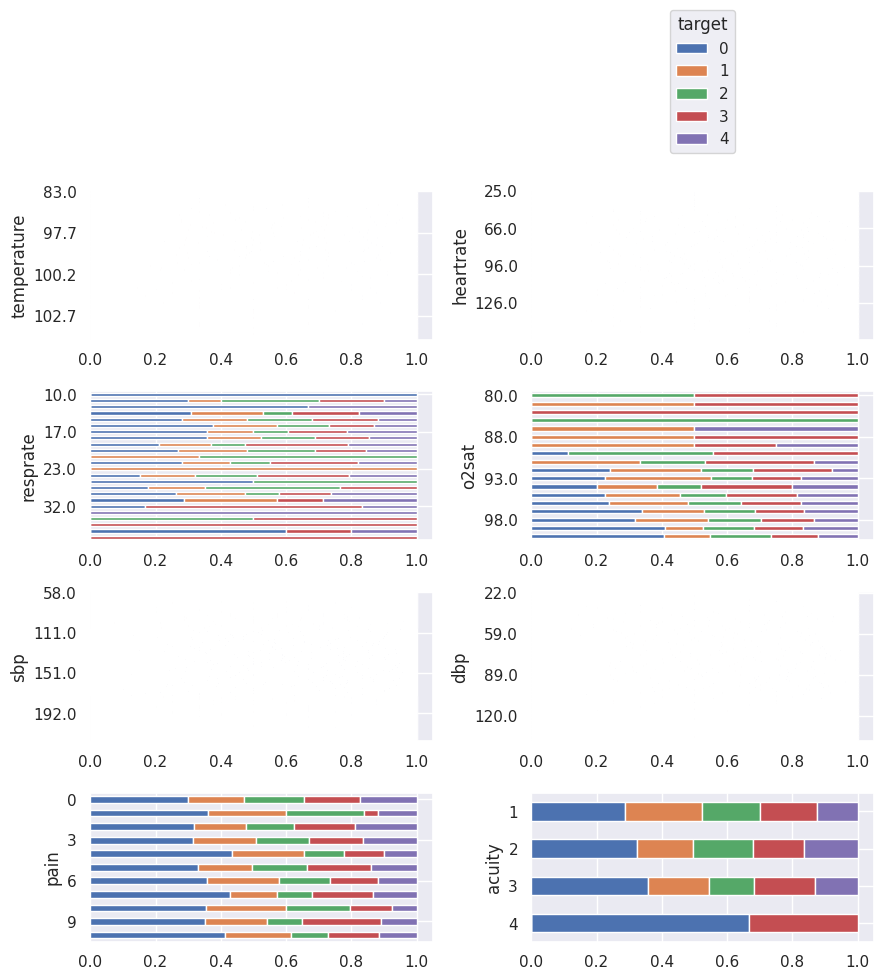

In [23]:
import matplotlib.ticker as ticker

features_to_plot = [col for col in alltrdata.columns if col != 'target']

fig, ax = plt.subplots(4, 2, figsize=(9, 4*2.5))  # 4 rows, 2 columns

for idx, col in enumerate(features_to_plot):
    row = idx // 2  # Integer division to find the row index
    col_idx = idx % 2  # Modulus to find the column index within a row
    rate_plot(col, 'target', alltrdata, ax=ax[row, col_idx])
    
    # Reduce the number of y-axis ticks
    ax[row, col_idx].yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))  # Adjust 'nbins' as needed

# Adjust legend placement to avoid overlap with the plots
ax[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.2), title='target')

fig.tight_layout()
plt.show()

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,target
temperature,1.000000,0.250000,0.030000,-0.070000,0.010000,-0.040000,0.090000,-0.030000,0.040000
heartrate,0.250000,1.000000,0.170000,-0.080000,-0.110000,0.150000,0.120000,-0.180000,0.010000
resprate,0.030000,0.170000,1.000000,-0.110000,-0.010000,-0.000000,0.060000,-0.200000,0.090000
o2sat,-0.070000,-0.080000,-0.110000,1.000000,0.060000,0.070000,0.020000,0.110000,-0.120000
sbp,0.010000,-0.110000,-0.010000,0.060000,1.000000,0.530000,-0.010000,0.120000,0.000000
dbp,-0.040000,0.150000,-0.000000,0.070000,0.530000,1.000000,0.060000,0.020000,-0.060000
pain,0.090000,0.120000,0.060000,0.020000,-0.010000,0.060000,1.000000,0.120000,-0.100000
acuity,-0.030000,-0.180000,-0.200000,0.110000,0.120000,0.020000,0.120000,1.000000,-0.030000
target,0.040000,0.010000,0.090000,-0.120000,0.000000,-0.060000,-0.100000,-0.030000,1.000000


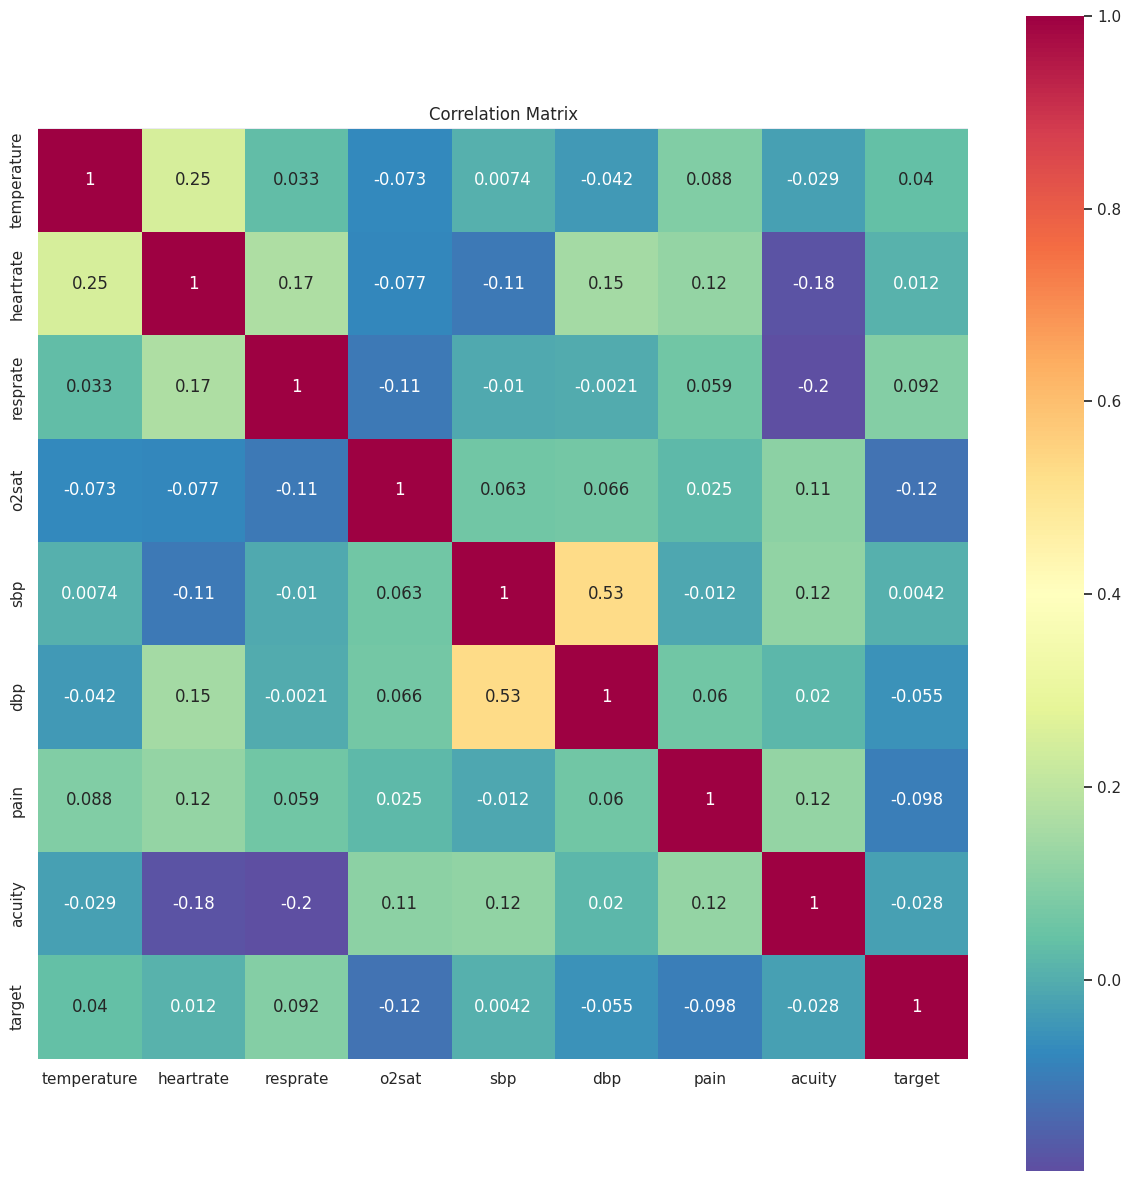

In [24]:
# using Seaborn & Pearson's correlation
corrmatrix=alltrdata.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corrmatrix,annot=True, square=True, cmap='Spectral_r')
plt.title('Correlation Matrix')
corrmatrix.round(2).style.background_gradient(cmap='coolwarm', axis=None)

## Data Preparation


### Define Data Types for Modeling Purposes

In [25]:
# Define data type columns
ordinal_cols = ['pain', 'acuity']
ratio_cols   = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']

### Preprocess parameters

In [26]:
# Preprocess parameters
impOrd   = SimpleImputer(strategy='constant', fill_value=-1)
impRatio = SimpleImputer(strategy='mean')
scale    = RobustScaler(with_centering=False)
encode   = OrdinalEncoder()

### Preprocess Pipeline

In [27]:
# Simple imputing Preprocess
ord_pp_steps  = Pipeline([('missing',impOrd),('Ordinal',encode),('Scale',scale)])
ratio_pp_steps= Pipeline([('mean',impRatio),('Scale',scale)])

# create the preprocessor stage of final pipeline
t=[("ordinal",ord_pp_steps,ordinal_cols),('ratio',ratio_pp_steps ,ratio_cols)]
preprocessor = ColumnTransformer(transformers = t)

## Model Parameters/Pipeline

### Cross Validation Parameters

In [28]:
# Cross Validation options
cvdict={
    'cv5-0'  : StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED),
    'cv3-2'  : RepeatedStratifiedKFold(n_splits=3,  n_repeats=2,  random_state=RANDOM_SEED),
    'cv3-10' : RepeatedStratifiedKFold(n_splits=3,  n_repeats=10, random_state=RANDOM_SEED),
    'cv5-2'  : RepeatedStratifiedKFold(n_splits=5,  n_repeats=2,  random_state=RANDOM_SEED),
    'cv5-10' : RepeatedStratifiedKFold(n_splits=5,  n_repeats=10, random_state=RANDOM_SEED),
    'cv10-0' : StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED),
    'cv10-2' : RepeatedStratifiedKFold(n_splits=10, n_repeats=2,  random_state=RANDOM_SEED),
    'cv10-10': RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=RANDOM_SEED)
}

In [29]:
cv = cvdict['cv5-2']       # for now

### Estimator

In [30]:
# Initial parametres 
xgb_def = XGBClassifier(random_state=            RANDOM_SEED,
                    #General  parameters     (*) indicates key param and should be tuned
                    booster=                 'gbtree',   
                    verbosity=               2,          
                    validate_parameters=     False,  #Give warnings for unknown parameter
                    n_jobs=                  -1,

                    #Boosting parameters             (*) indicates key param to be tuned in the given order
                    learning_rate=           0.05,   #1(*) LR: [2-10]/M  (0.01; 0.015; 0.025; 0.05; 0.1)
                    n_estimators=            100,    #2(*) M: 100 - 1000
                    max_depth=               5,      #3(*) 3 - 25
                    min_child_weight=        20,     #3(*) 1,3,5,7
                    gamma=                   0,      #4(*) 0.05;0.1;0.3;0.5;0.7;0.9;1
                    subsample=               0.8,    #5(*) 0.5 - 1.0 
                    colsample_bytree=        0.2,    #5(*) 0.3 - 1.0 
                    colsample_bylevel=       1.0,    #     Subsample ratio of columns for each level
                    colsample_bynode=        1.0,    #     Subsample ratio of columns for each split
                    reg_alpha=               0,      #6(*) L1 0;0.1;0.5;1
                    reg_lambda=              1,      #6(*) L2 0.01;0.1;1
                    #scale_pos_weight=        1,      #7(*) higher is for imbalance class (not used for multi class)
                    max_delta_step=          0,      #7(*) 
                    num_parallel_tree=       1,      #Used for boosting random forest
                    monotone_constraints=    None,   #Constraint of variable monotonicity
                    interaction_constraints= None,   #Constraints for interaction representing permitted interactions

                    #Learning Task  parameters
                    objective=               'multi:softmax',  # For multi-class classification
                    num_class=               5,                # Specify the number of unique classes
                    tree_method=             'auto', #8(*) Specify which tree method to use
                    base_score=              0.5,    #initial prediction score of all instances, global bias

                    #Misc parameters                 (*) indicates key param
                    missing=                 nan,    #Value in the data which needs to be present as a missing value
                    importance_type=         'gain', #feature importance type for the feature_importances_ property
                    gpu_id=                  None,   #Device ordinal
)

## Model Tuning

### Model Pipeline

In [31]:
# Setup pipeline
pipe = Pipeline([('preprocess',preprocessor), ('estimator', xgb_def)])

### Initial Hyperparameters

In [32]:
# Setup default parameters for gridsearch
params={
        #Boosting parameters
        'estimator__learning_rate':    [0.05,0.01,0.005],   
        'estimator__n_estimators':     range(200,500,20),
        'estimator__max_depth':        [1,2],    
        'estimator__min_child_weight': [1,2],
        'estimator__gamma':            [0],
        'estimator__subsample':        [0.5,0.7],  
        'estimator__colsample_bytree': [0.25],
        'estimator__colsample_bylevel':[0.],
        'estimator__colsample_bynode': [0.],
        'estimator__reg_alpha':        [0, 0.5],
        'estimator__reg_lambda':       [0.],
        #'estimator__scale_pos_weight': [1],  # Not used for multi classifications
        'estimator__max_delta_step':   [0],   # 0 for no constraint
        'estimator__monotone_constraints':    [None],
        'estimator__interaction_constraints': [None],
        #Learning task parameters
        'estimator__tree_method':      ['hist'],
        'estimator__base_score':       [0.5],
}

### Hyperparameters Tuning

In [33]:
#begin gridsearch
auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr', average='weighted')
Grid = GridSearchCV(pipe, param_grid=params,
                    scoring={'neg_log_loss': 'neg_log_loss',
                             'roc_auc_ovr': auc_scorer},
                    return_train_score=True,
                    refit='roc_auc_ovr',
                    cv=cv,
                    verbose=1, n_jobs=-1).fit(X_train, y_train)

# Create dataframe of the results for comparison & analysis
Griddf = pd.DataFrame(Grid.cv_results_)

# Print the best AUC score and associated parameters
print("Best AUC Score: ", Grid.best_score_)
print("Best Parameters: ", Grid.best_params_)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits
Best AUC Score:  0.6024009488045208
Best Parameters:  {'estimator__base_score': 0.5, 'estimator__colsample_bylevel': 0.0, 'estimator__colsample_bynode': 0.0, 'estimator__colsample_bytree': 0.25, 'estimator__gamma': 0, 'estimator__interaction_constraints': None, 'estimator__learning_rate': 0.05, 'estimator__max_delta_step': 0, 'estimator__max_depth': 1, 'estimator__min_child_weight': 1, 'estimator__monotone_constraints': None, 'estimator__n_estimators': 320, 'estimator__reg_alpha': 0.5, 'estimator__reg_lambda': 0.0, 'estimator__subsample': 0.5, 'estimator__tree_method': 'hist'}


In [34]:
Griddf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__base_score,param_estimator__colsample_bylevel,param_estimator__colsample_bynode,param_estimator__colsample_bytree,param_estimator__gamma,param_estimator__interaction_constraints,param_estimator__learning_rate,param_estimator__max_delta_step,param_estimator__max_depth,param_estimator__min_child_weight,param_estimator__monotone_constraints,param_estimator__n_estimators,param_estimator__reg_alpha,param_estimator__reg_lambda,param_estimator__subsample,param_estimator__tree_method,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,split5_test_neg_log_loss,split6_test_neg_log_loss,split7_test_neg_log_loss,split8_test_neg_log_loss,split9_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss,split0_train_neg_log_loss,split1_train_neg_log_loss,split2_train_neg_log_loss,split3_train_neg_log_loss,split4_train_neg_log_loss,split5_train_neg_log_loss,split6_train_neg_log_loss,split7_train_neg_log_loss,split8_train_neg_log_loss,split9_train_neg_log_loss,mean_train_neg_log_loss,std_train_neg_log_loss,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,split2_test_roc_auc_ovr,split3_test_roc_auc_ovr,split4_test_roc_auc_ovr,split5_test_roc_auc_ovr,split6_test_roc_auc_ovr,split7_test_roc_auc_ovr,split8_test_roc_auc_ovr,split9_test_roc_auc_ovr,mean_test_roc_auc_ovr,std_test_roc_auc_ovr,rank_test_roc_auc_ovr,split0_train_roc_auc_ovr,split1_train_roc_auc_ovr,split2_train_roc_auc_ovr,split3_train_roc_auc_ovr,split4_train_roc_auc_ovr,split5_train_roc_auc_ovr,split6_train_roc_auc_ovr,split7_train_roc_auc_ovr,split8_train_roc_auc_ovr,split9_train_roc_auc_ovr,mean_train_roc_auc_ovr,std_train_roc_auc_ovr
0,0.287617,0.023733,0.018486,0.003797,0.5,0.0,0.0,0.25,0,None,0.05,0,1,1,None,200,0,0.0,0.5,hist,"{'estimator__base_score': 0.5, 'estimator__col...",-1.520184,-1.518306,-1.536820,-1.509305,-1.534684,-1.521172,-1.516007,-1.533026,-1.533154,-1.530823,-1.525348,0.008983,65,-1.485117,-1.484488,-1.477390,-1.488129,-1.477451,-1.482632,-1.483252,-1.480541,-1.479763,-1.482077,-1.482084,0.003232,0.612896,0.606237,0.579506,0.629569,0.589585,0.606784,0.619721,0.591136,0.585758,0.584765,0.600596,0.015978,167,0.661354,0.664814,0.669914,0.660228,0.665482,0.664251,0.662860,0.667755,0.669498,0.667529,0.665368,0.003138
1,0.311555,0.036546,0.022151,0.002997,0.5,0.0,0.0,0.25,0,None,0.05,0,1,1,None,200,0,0.0,0.7,hist,"{'estimator__base_score': 0.5, 'estimator__col...",-1.525386,-1.518472,-1.539245,-1.513771,-1.535333,-1.527189,-1.516567,-1.528611,-1.533383,-1.532360,-1.527032,0.008066,124,-1.484496,-1.485700,-1.478643,-1.488214,-1.477975,-1.483780,-1.483673,-1.481971,-1.480059,-1.483276,-1.482779,0.003022,0.605310,0.606488,0.574563,0.621827,0.590944,0.597871,0.619106,0.596782,0.586976,0.582333,0.598220,0.014511,561,0.662212,0.663311,0.670460,0.660302,0.666977,0.662793,0.661918,0.666468,0.670523,0.666112,0.665108,0.003385
2,0.244290,0.075838,0.019604,0.005175,0.5,0.0,0.0,0.25,0,None,0.05,0,1,1,None,200,0.5,0.0,0.5,hist,"{'estimator__base_score': 0.5, 'estimator__col...",-1.521549,-1.517658,-1.534184,-1.508907,-1.534970,-1.521207,-1.516446,-1.532617,-1.531616,-1.529682,-1.524884,0.008483,47,-1.488448,-1.487805,-1.481146,-1.491577,-1.480621,-1.486080,-1.486164,-1.483873,-1.483426,-1.485314,-1.485445,0.003185,0.610522,0.607687,0.582717,0.630821,0.588566,0.607442,0.619480,0.591757,0.587727,0.585574,0.601229,0.015478,102,0.658451,0.662085,0.666419,0.657164,0.662588,0.661839,0.660490,0.664065,0.666972,0.665182,0.662526,0.003075
3,0.173279,0.010943,0.015697,0.002538,0.5,0.0,0.0,0.25,0,None,0.05,0,1,1,None,200,0.5,0.0,0.7,hist,"{'estimator__base_score': 0.5, 'estimator__col...",-1.525252,-1.518910,-1.535899,-1.514033,-1.536425,-1.526002,-1.517487,-1.530387,-1.531320,-1.531382,-1.526710,0.007380,116,-1.487576,-1.488670,-1.482042,-1.491212,-1.480860,-1.486899,-1.486720,-1.485059,-1.483451,-1.486526,-1.4

### Updated Estimator & Model Pipeline

In [35]:
# updated estimators 
uxgb = XGBClassifier(random_state=            RANDOM_SEED,
                    #General  parameters     (*) indicates key param and should be tuned
                    booster=                 'gbtree',   
                    verbosity=               2,          
                    validate_parameters=     False,  #Give warnings for unknown parameter
                    n_jobs=                  -1,

                    #Boosting parameters             (*) indicates key param to be tuned in the given order
                    learning_rate=           0.05,   #1(*) LR: [2-10]/M  (0.01; 0.015; 0.025; 0.05; 0.1)
                    n_estimators=            320,    #2(*) M: 100 - 1000
                    max_depth=               1,      #3(*) 3 - 25
                    min_child_weight=        1,     #3(*) 1,3,5,7
                    gamma=                   0.,      #4(*) 0.05;0.1;0.3;0.5;0.7;0.9;1
                    subsample=               0.5,    #5(*) 0.5 - 1.0 
                    colsample_bytree=        0.25,    #5(*) 0.3 - 1.0 
                    colsample_bylevel=       0.0,    #     Subsample ratio of columns for each level
                    colsample_bynode=        0.0,    #     Subsample ratio of columns for each split
                    reg_alpha=               0.5,      #6(*) L1 0;0.1;0.5;1
                    reg_lambda=              0,      #6(*) L2 0.01;0.1;1
                    #scale_pos_weight=        1,      #7(*) higher is for imbalance class (not used for multi class)
                    max_delta_step=          0.,      #7(*) 
                    num_parallel_tree=       1,      #Used for boosting random forest
                    monotone_constraints=    None,   #Constraint of variable monotonicity
                    interaction_constraints= None,   #Constraints for interaction representing permitted interactions

                    #Learning Task  parameters
                    objective=               'multi:softmax',  # For multi-class classification
                    num_class=               5,                # Specify the number of unique classes
                    tree_method=             'hist', #8(*) Specify which tree method to use
                    base_score=              0.5,    #initial prediction score of all instances, global bias

                    #Misc parameters                 (*) indicates key param
                    missing=                 nan,    #Value in the data which needs to be present as a missing value
                    importance_type=         'gain', #feature importance type for the feature_importances_ property
                    gpu_id=                  None,   #Device ordinal
)

In [36]:
# Update pipeline
u_pipe = Pipeline([('preprocess',preprocessor), ('estimator', uxgb)])

## Testing

### Fit and save probabilities for training data

In [38]:
# Fit and save train probabilities for EF model

# Fit the training data
u_pipe.fit(X_train, y_train)

# Predict probabilities for training data
train_probs = u_pipe.predict_proba(X_train)

# Binarize the train labels for AUC calculation
y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))

# Calculate AUC (One-vs-Rest) for each class individually
individual_aucs = {}
for i, class_label in enumerate(np.unique(y_train)):
    individual_auc = roc_auc_score(y_train_binarized[:, i], train_probs[:, i])
    individual_aucs[class_label] = individual_auc
    print(f"Train AUC for class {class_label}: {individual_auc}")

# Convert the predicted probabilities to a DataFrame, using the same index as X_train
train_probs_df = pd.DataFrame(train_probs, columns=[f'Class_{i}_Prob' for i in range(len(np.unique(y_train)))], index=X_train.index)

# Save to CSV, the index (patient_id) will be the first column
train_probs_df.to_csv('tabular_train_class_probabilities_4_1_24.csv')

print("Saved predicted class probabilities for training set to 'tabular_train_class_probabilities.csv'")

Train AUC for class 0: 0.6655215259729301
Train AUC for class 1: 0.6497382724412956
Train AUC for class 2: 0.6777477541539263
Train AUC for class 3: 0.664111086565046
Train AUC for class 4: 0.6469114666133042
Saved predicted class probabilities for training set to 'tabular_train_class_probabilities.csv'


### Compute and save AUC and probabilities for validation data

In [39]:
# Predict and save validation probabilities for EF model

# Predict probabilities
test_prob = u_pipe.predict_proba(X_test)

# Binarize the validation labels for AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))

# Convert the predicted probabilities to a DataFrame, using the same index as X_test
test_probs_df = pd.DataFrame(test_prob, columns=[f'Class_{i}_Prob' for i in range(len(np.unique(y_train)))], index=X_test.index)

# Save to CSV, the index (patient_id) will be the first column
test_probs_df.to_csv('tabular_validate_class_probabilities_4_1_24.csv')  # remember that this set is actually the validation set

print("Saved predicted class probabilities for validation set to 'tabular_validate_class_probabilities.csv'")

Saved predicted class probabilities for validation set to 'tabular_validate_class_probabilities.csv'


AUC for class 0: 0.6246699270323901
AUC for class 1: 0.5698257340654094
AUC for class 2: 0.6260484932129218
AUC for class 3: 0.6586630852550663
AUC for class 4: 0.5564957017289676

Average AUC (One-vs-Rest): 0.621500695752916


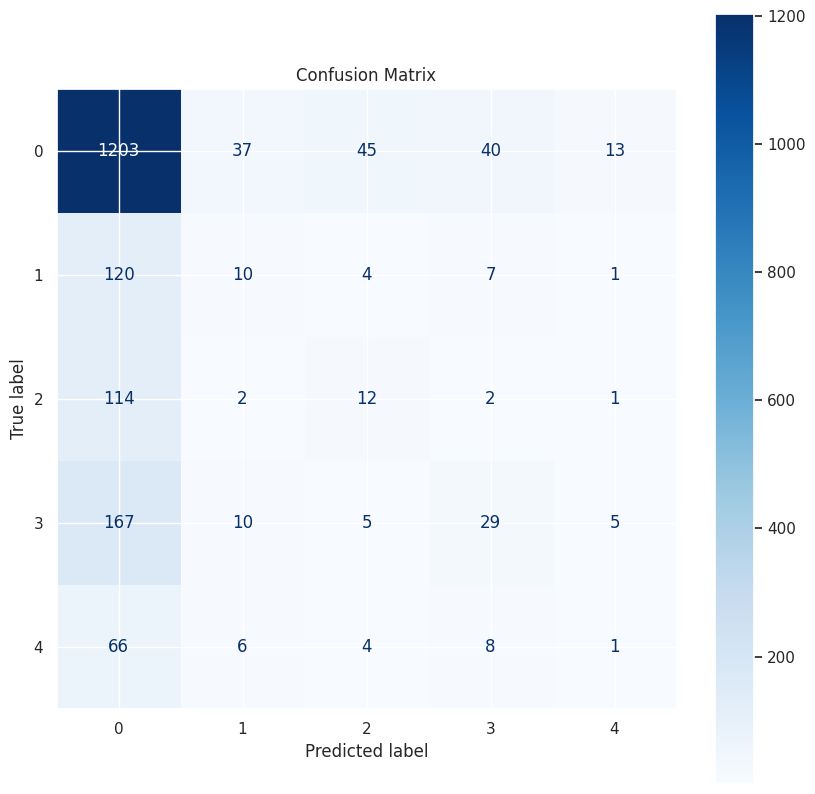

In [40]:
# Compute, print and plot evaluation metrics

# Binarize the test labels for AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))

# Calculate individual AUC scores for each class
for i, class_label in enumerate(np.unique(y_train)):
    class_auc = roc_auc_score(y_test_binarized[:, i], test_prob[:, i])
    print(f"AUC for class {class_label}: {class_auc}")

# Calculate AUC (One-vs-Rest) - average AUC across all classes
auc_ovr = roc_auc_score(y_test_binarized, test_prob, multi_class='ovr', average='weighted')
print(f"\nAverage AUC (One-vs-Rest): {auc_ovr}")

# Predict classes for confusion matrix
test_pred = u_pipe.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, test_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Compute and save AUC and probabilities for test data

In [41]:
# Had erros when testing. It looks like X_test['acuity'] has '5' which did not exist in train data 
print(X_train['pain'].unique())
print(X_train['acuity'].unique())
print(X_testtest['pain'].unique())
print(X_testtest['acuity'].unique())

<IntegerArray>
[0, 10, 9, 8, 7, 4, 6, 5, 1, 3, 2]
Length: 11, dtype: Int64
<IntegerArray>
[2, 3, 1, 4]
Length: 4, dtype: Int64
<IntegerArray>
[8, 0, 10, 5, 3, 4, 2, 1, 6, 7, 9]
Length: 11, dtype: Int64
<IntegerArray>
[1, 2, 3, 4, 5]
Length: 5, dtype: Int64


In [42]:
# Check the number of records with '5' in the 'acuity' column
num_records_with_5 = X_testtest[X_testtest['acuity'] == 5].shape[0]
print(f"Number of records with '5' in the 'acuity' column: {num_records_with_5}")

Number of records with '5' in the 'acuity' column: 1


In [43]:
# Remove that record since it is only 1

# Filter out records where 'acuity' is 5
X_testtest = X_testtest[X_testtest['acuity'] != 5]
y_testtest = y_testtest.loc[X_testtest.index]

# Verify the filtering
print(f"Shape of X_testtest after filtering: {X_testtest.shape}")
print(f"Shape of y_testtest after filtering: {y_testtest.shape}")

Shape of X_testtest after filtering: (1910, 8)
Shape of y_testtest after filtering: (1910, 1)


In [44]:
# Predict and save actual test probabilities for EF model

# Predict probabilities
testtest_prob = u_pipe.predict_proba(X_testtest)

# Binarize the test labels for AUC calculation
y_testtest_binarized = label_binarize(y_testtest, classes=np.unique(y_train))

# Convert the predicted probabilities to a DataFrame, using the same index as X_testtest
testtest_probs_df = pd.DataFrame(testtest_prob, columns=[f'Class_{i}_Prob' for i in range(len(np.unique(y_train)))], index=X_testtest.index)

# Save to CSV, the index (patient_id) will be the first column
testtest_probs_df.to_csv('tabular_test_class_probabilities_4-1-24.csv')

print("Saved predicted class probabilities for test set to 'tabular_test_class_probabilities.csv'")

Saved predicted class probabilities for test set to 'tabular_test_class_probabilities.csv'


AUC for class 0: 0.6357884169540082
AUC for class 1: 0.5183557642149191
AUC for class 2: 0.6140216890002158
AUC for class 3: 0.6204338938344873
AUC for class 4: 0.6164265625896803

Average AUC (One-vs-Rest): 0.623393311419342


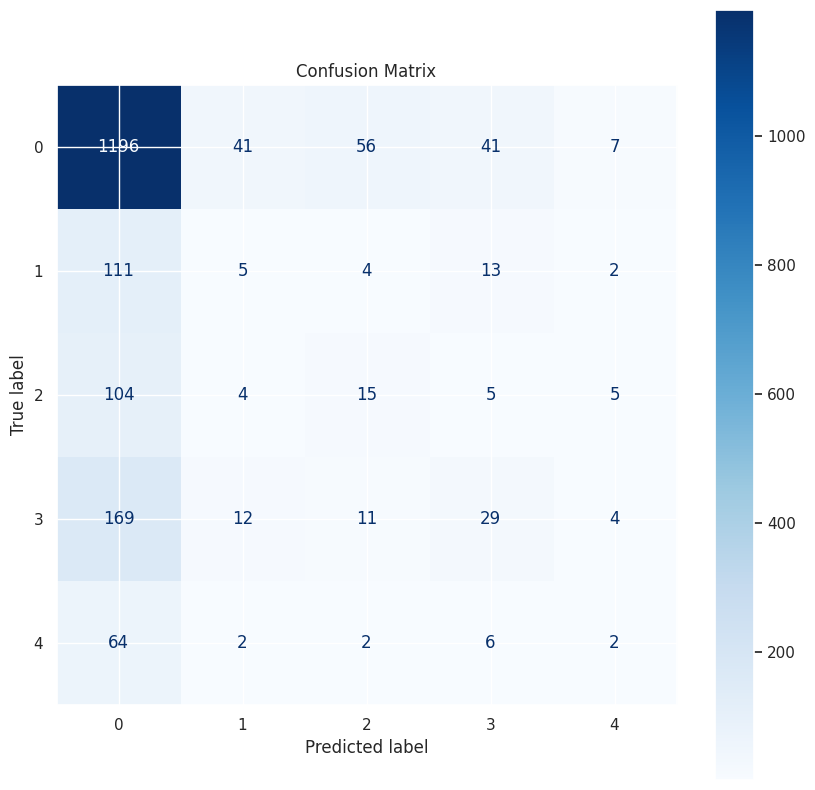

In [45]:
# Compute, print and plot evaluation metrics

# Binarize the test labels for AUC calculation
y_testtest_binarized = label_binarize(y_testtest, classes=np.unique(y_train))

# Calculate individual AUC scores for each class
for i, class_label in enumerate(np.unique(y_train)):
    class_auc = roc_auc_score(y_testtest_binarized[:, i], testtest_prob[:, i])
    print(f"AUC for class {class_label}: {class_auc}")

# Calculate AUC (One-vs-Rest) - average AUC across all classes
auc_ovr = roc_auc_score(y_testtest_binarized, testtest_prob, multi_class='ovr', average='weighted')
print(f"\nAverage AUC (One-vs-Rest): {auc_ovr}")

# Predict classes for confusion matrix
testtest_pred = u_pipe.predict(X_testtest)

# Compute confusion matrix
cm = confusion_matrix(y_testtest, testtest_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Miscellenous Tasks

### Save Model

In [46]:
# using joblib
joblib.dump(u_pipe, 'tabular_model_F.joblib')

# usin gpickle
with open('tabular_model_F.pkl', 'wb') as file:
    pickle.dump(u_pipe, file)